<a href="https://colab.research.google.com/github/ik-ingkarat/229352-StatisticalLearning/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)), #Resizeทุกภาพ
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset), # ทั้งก้อนเพราะ val ไม่ตองการความหลากหลาย
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

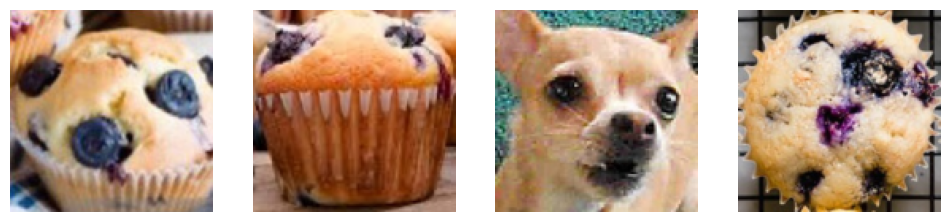

tensor([1, 1, 0, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 128 * 3, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.activation(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [10]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [11]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [12]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [13]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [14]:
train_batches = iter(train_loader)
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [15]:
y_hat = model(X)
y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)


#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [16]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())
train_losses

[0.6931471824645996]

#### Calculate the gradient (Backward pass)

In [17]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [18]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        if param.grad is not None: # Check if gradient exists
            param.data -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [19]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [20]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[1.180568814277649]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

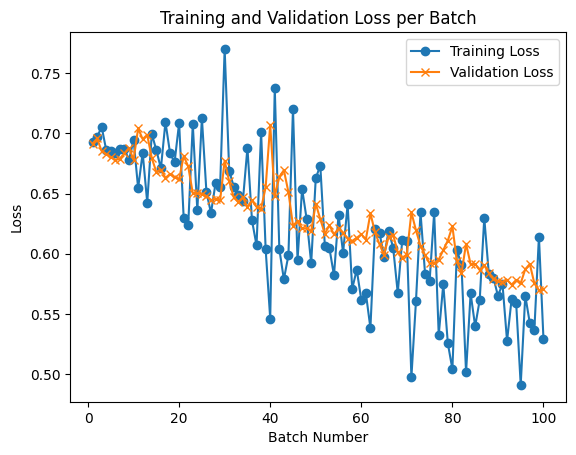

In [21]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [22]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


In [23]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3 * 128 * 128, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 1)
        self.act1 = nn.ReLU()
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.linear1(x))
        x = self.act1(self.linear2(x))
        x = self.act1(self.linear3(x))
        x = self.activation(self.linear4(x))
        return x

In [24]:
def train_model(train_loader, test_loader, learning_rate, epochs=5):
    model = SimpleLogisticRegression()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs.view(-1), y.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Compute test accuracy
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for X, y in test_loader:
            y_hat = model(X)
            y_hat = (y_hat.view(-1) > 0.5).float()
            correct += (y_hat == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"Test Accuracy @ lr={learning_rate}: {acc:.4f}")
    return model, acc

In [27]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
# เทรนด้วย learning rates ต่างๆ
for lr in learning_rates:
    model, acc = train_model(train_loader, test_loader, learning_rate=lr, epochs=10)

import matplotlib.pyplot as plt

def evaluate_and_show_misclassified(model, test_loader):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for X, y in test_loader:
            y_hat = model(X)
            y_hat = (y_hat.view(-1) > 0.5).float()

            for i in range(len(y)):
                if y_hat[i] != y[i]:
                    misclassified_images.append(X[i])
                    misclassified_labels.append(y[i].item())
                    misclassified_preds.append(y_hat[i].item())

            if len(misclassified_images) >= 4:
                break

    # แสดงผล 4 ภาพแรกที่ทำนายผิด
    plt.figure(figsize=(10, 6))
    for i in range(4):
        img = misclassified_images[i].permute(1, 2, 0)  # C,H,W → H,W,C
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"True: {misclassified_labels[i]}, Pred: {int(misclassified_preds[i])}")
        plt.axis("off")
    plt.show()

Epoch [1/10], Loss: 49.0688
Epoch [2/10], Loss: 53.0000
Epoch [3/10], Loss: 53.6667
Epoch [4/10], Loss: 53.0000
Epoch [5/10], Loss: 52.3333
Epoch [6/10], Loss: 52.3333
Epoch [7/10], Loss: 51.6667
Epoch [8/10], Loss: 53.0000
Epoch [9/10], Loss: 53.6667
Epoch [10/10], Loss: 52.3333
Test Accuracy @ lr=0.01: 0.4333
Epoch [1/10], Loss: 1.3941
Epoch [2/10], Loss: 1.1613
Epoch [3/10], Loss: 0.5074
Epoch [4/10], Loss: 0.5985
Epoch [5/10], Loss: 0.4782
Epoch [6/10], Loss: 0.2649
Epoch [7/10], Loss: 0.2167
Epoch [8/10], Loss: 0.2621
Epoch [9/10], Loss: 0.3797
Epoch [10/10], Loss: 0.1301
Test Accuracy @ lr=0.001: 0.8333
Epoch [1/10], Loss: 0.7416
Epoch [2/10], Loss: 0.7040
Epoch [3/10], Loss: 0.6219
Epoch [4/10], Loss: 0.5764
Epoch [5/10], Loss: 0.4859
Epoch [6/10], Loss: 0.4484
Epoch [7/10], Loss: 0.3577
Epoch [8/10], Loss: 0.3243
Epoch [9/10], Loss: 0.2933
Epoch [10/10], Loss: 0.3017
Test Accuracy @ lr=0.0001: 0.7000
Epoch [1/10], Loss: 0.6954
Epoch [2/10], Loss: 0.6765
Epoch [3/10], Loss: 0.65

In [ ]:
# 2.1 What value of learning rate do you think is the best? Please explain your reason.
# - 1e-3 ดีที่สุด เพราะให้ผล Accuracy การเทรนที่ดี

#2.2 What happens to the training losses if your learning rate is too large?
# - loss จะไม่เสถียรและ โมเดลอาจไม่เรียนรู้สิ่งที่ถูกต้อง

#2.3 What happens to the training losses if your learning rate is too small?
# - loss จะค่อย ๆ ลดอย่างช้าๆ และโมเดลอาจเรียนรู้ไม่ทันเวลา
